# Reclassify Unsupervised NDVI

## Background

## Description


In this notebook, we will reclassify the K-means Clustering prediction results using the groups created in the [previous notebook](02_group_classes_using_NDVI.ipynb).


---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import datacube
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from tqdm import tqdm
import glob

from datacube.utils import geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from deafrica_tools.dask import create_local_dask_cluster
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from random_sampling import random_sampling

### Analysis parameters

The following cell sets important parameters for the analysis:

* `output_dir` : The directory in which to store results from the analysis.
* `commune`:  This is the Niger commune/administrative post selected for analysis in the [Unsupervised Class Identification notebook](01_unsupervised_class_identification.ipynb). 
* `no_of_clusters` : The number of clusters used in the K-Means clustering in the [Unsupervised Class Identification notebook](01_unsupervised_class_identification.ipynb).
* `time_01 and time_02` : These are time periods of interest from the [Unsupervised Class Identification notebook](01_unsupervised_class_identification.ipynb) and [Group Classes Using NDVI notebook](02_group_classes_using_NDVI.ipynb).
* `ndvi_timeseries_fp` : File path to the time series saved from the [Group Classes Using NDVI notebook](02_group_classes_using_NDVI.ipynb).
* `pickled_prediction` : The file path to the pickled clustering prediction result from the [Unsupervised Class Identification notebook](01_unsupervised_class_identification.ipynb).
* `ndvi_groups_fn` : File name pattern to use when searching for the pickled NDVI profiles files from the [Group Classes Using NDVI notebook](02_group_classes_using_NDVI.ipynb).
* `ndvi_loners_fn` : The file path for the pickled NDVI profile  for the loner classes from the [Group Classes Using NDVI notebook](02_group_classes_using_NDVI.ipynb).

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [2]:
# Directory to store the results.
output_dir = "results"

# Select a commune/adminstrative post, a complete list of communes/adminstrative posts is available below.
commune = "BIRNI NGAOURE"
commune_name = commune.replace(" ", "_")

# The number of clusters used in the K-Means clustering in the previous notebook. 
no_of_clusters = 15

# Time periods of interest from the previous notebook.
time_01 = "2021"
time_02 = ("15-10-2020", "15-02-2022") 

# File paths of results from the previouse notebook.
ndvi_timeseries_fp = f"{output_dir}/{commune_name}_ndvitimeseries_{time_02[0]}_to_{time_02[1]}_{no_of_clusters}classes.csv"
pickled_prediction = f"{output_dir}/{commune_name}_kmeans_{no_of_clusters}classes_predicted_{time_01}.pickle"
ndvi_groups_fn = f"{output_dir}/{commune_name}_correlated_ndvi_{time_02[0]}_to_{time_02[1]}_{no_of_clusters}classes_group*.pickle"
ndvi_loners_fn = f"{output_dir}/{commune_name}_correlated_ndvi_{time_02[0]}_to_{time_02[1]}_{no_of_clusters}classes_loner_classes.pickle"

## Read in the  NDVI time series per K-means class from the previous notebook

In [3]:
timeseries_df = pd.read_csv(ndvi_timeseries_fp, index_col="time")
timeseries_df.head()

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
time,,,,,,,,,,,,,,,
2020-10-18,0.217986,0.269975,0.193822,0.122486,0.158831,0.231513,0.313564,0.251637,0.267249,0.204232,0.165901,0.325904,0.236464,0.178544,0.298416
2020-11-01,0.203567,0.266990,0.183328,0.300387,0.263813,0.228372,0.320620,0.246184,0.264568,0.198296,0.154012,0.371517,0.235255,0.177625,0.298142
2020-11-15,0.192655,0.247012,0.174974,0.267257,0.248508,0.213842,0.295449,0.225624,0.245158,0.184993,0.148801,0.340838,0.218840,0.168870,0.270970
2020-11-29,0.187744,0.239325,0.170298,0.261486,0.247042,0.206905,0.287645,0.214820,0.237063,0.177215,0.145386,0.335189,0.210040,0.162813,0.257886
2020-12-13,0.183636,0.232570,0.165246,0.254700,0.248165,0.198949,0.280147,0.203067,0.229200,0.167882,0.141259,0.329799,0.201706,0.155897,0.244074


## Read in pickled K-means Clustering prediction results from the previous notebook

In [4]:
# Read in the K-means Clustering pickled prediction data as a dictionary.
with open(pickled_prediction, "rb") as f:
    x_val, y_val, pred_val, pred_crs = pickle.load(f)

In [5]:
# Format the loaded predicted data into an xarray.DataArray.
predicted = xr.DataArray(
    data=pred_val,
    dims=["y", "x"],
    coords=dict(
        x=x_val,
        y=y_val,
    ),
    attrs=dict(
        crs=pred_crs,
    ),
).transpose("y", "x")

print(predicted)

<xarray.DataArray (y: 1578, x: 1282)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 2.636e+05 2.636e+05 2.637e+05 ... 2.892e+05 2.892e+05
  * y        (y) float64 1.67e+06 1.669e+06 1.669e+06 ... 1.638e+06 1.638e+06
Attributes:
    crs:      EPSG:6933


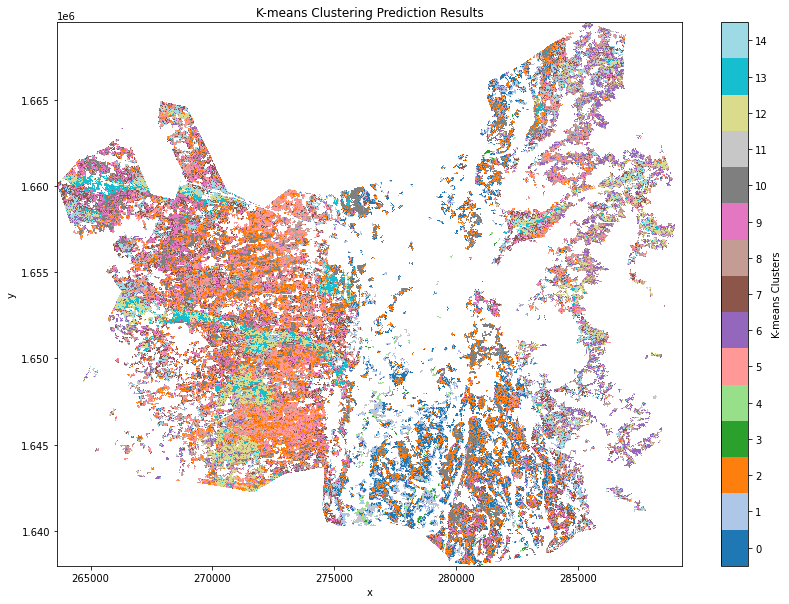

In [6]:
## Plot the predicted results.
# Create a list of labels to use for your legend.
classes_present = [x for x in list(np.unique(predicted)) if np.isnan(x) == False]

# Create a colormap.
cmap = plt.cm.get_cmap("tab20", len(classes_present))
class_bins = list(np.arange(np.min(classes_present)-0.5 , np.max(classes_present)+1+0.5, 1))
norm = mpl.colors.BoundaryNorm(class_bins, len(classes_present))

fig, ax = plt.subplots(figsize=(14,10))
im = predicted.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False, ax=ax)
cbar=plt.colorbar(im, label='K-means Clusters')
cbar.set_ticks(classes_present)
plt.title("K-means Clustering Prediction Results");

In [7]:
# Sample the K-Means clustering prediction results.
#predicted_sampled_points = random_sampling(da = predicted,
#                                           n = 1000,
#                                           sampling='equal_stratified_random',
#                                           manual_class_ratios=None,
#                                           out_fname=f"{output_dir}/kmeans_predicted_sample_points.geojson")

## Load the groups and loner classes from the previous notebooks

Grouped classes are the classes in the K-means clustering prediction results that were grouped together.

The loner classes are classes in the K-means clustering prediction results that were unable to be grouped in any way.

In [8]:
# Use the file pattern 'ndvi_groups_fn` to find the files to which the 
# groups created in the previous notebook `02_group_class_using_NDVI.ipynb` were
# exported to. 
files = sorted(glob.glob(ndvi_groups_fn))

# Starting point for naming the groups.
group_name = 1 

# Save the groups and their respective K-means Clustering prediction class values in a dictionary.
grouped_classes = {} 

for file in files:
    with open(file, "rb") as f:
        grouped_classes[group_name] = pickle.load(f)
        
    group_name+=1

    
# Load the loner classes.
# Each loner class is a group on its own.
with open(ndvi_loners_fn, "rb") as f:
    loner_classes = pickle.load(f)

for loner_class in loner_classes:
    grouped_classes[group_name] = loner_class
    group_name+=1
    
    
grouped_classes

{1: ['Class_0',
  'Class_1',
  'Class_2',
  'Class_5',
  'Class_6',
  'Class_7',
  'Class_8',
  'Class_9',
  'Class_10',
  'Class_11',
  'Class_12',
  'Class_13',
  'Class_14'],
 2: ['Class_3', 'Class_4']}

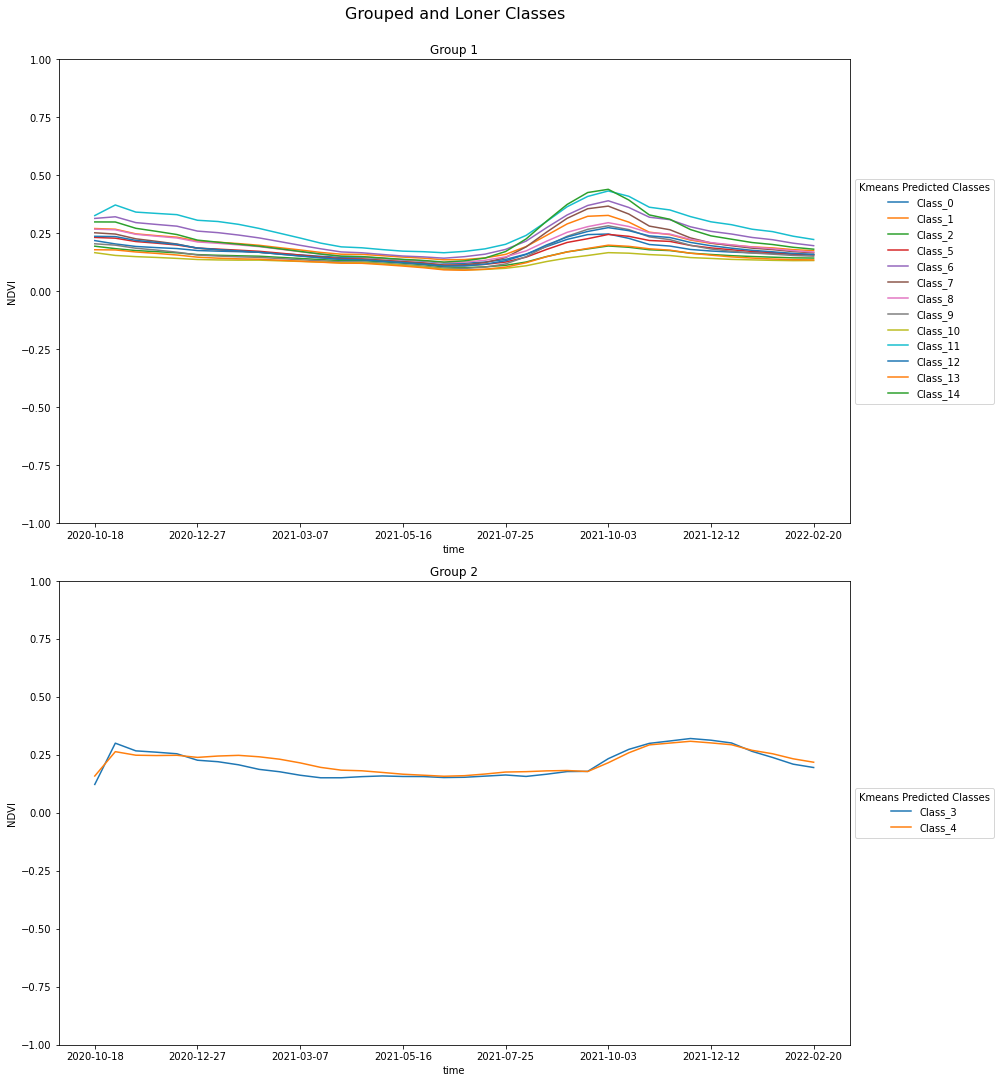

In [9]:
# Plot the grouped and loner K-means clustering predicted results classes.
# Each loner class is a group on its own.
fig = plt.figure(figsize=(14, 15), facecolor="white")
fig.suptitle('Grouped and Loner Classes', x=0.455 , y=1, fontsize=16)

rows = len(grouped_classes)
columns = 1

# Starting point for naming the groups.
group_name = 1 

for i in range(rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    for class_id in grouped_classes[group_name]:
        timeseries_df[class_id].plot(ax=ax)
    ax.legend(title= "Kmeans Predicted Classes", bbox_to_anchor=(1.0, 0.5), loc="center left")
    ax.set_ylim((-1, 1))
    ax.set_title(f"Group {group_name}")
    ax.set_ylabel("NDVI")
    group_name +=1
plt.tight_layout()

## Reclassify the prediction image

In [10]:
# Create a dictionary mapping each unique class in the Kmeans Clustering prediction image to its group value from the above section.
# For the loner classes, each class will have it's own group.
reclassification_dict = {} 

# For each group in the group_classes list. 
for group_name, group in grouped_classes.items():
    # Since each group contains a list of class values. 
    # Assign each class value in the list the group name in the dictionary.
    for class_value in group:
        class_value = int(class_value.lstrip('Class_'))
        reclassification_dict[class_value] = group_name

reclassification_dict

{0: 1,
 1: 1,
 2: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 3: 2,
 4: 2}

In [11]:
# Update the reclassification dict to take care of the np.nan values in the K-means prediction results.
reclassification_dict.update({np.nan : np.nan} )

# For each pixel in the predicted image assign the group name it belongs to.
sort_idx = np.argsort(list(reclassification_dict.keys()))
idx = np.searchsorted(list(reclassification_dict.keys()), predicted.data, sorter=sort_idx)
grouped_predicted_np = np.asarray(list(reclassification_dict.values()))[sort_idx][idx]

# Convert the grouped prediction image numpy array to a xarray.DataArray.
grouped_predicted = xr.DataArray(grouped_predicted_np,  coords=predicted.coords, dims=predicted.dims, attrs=predicted.attrs).astype(predicted.dtype)

grouped_predicted

<xarray.DataArray (y: 1578, x: 1282)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 2.636e+05 2.636e+05 2.637e+05 ... 2.892e+05 2.892e+05
  * y        (y) float64 1.67e+06 1.669e+06 1.669e+06 ... 1.638e+06 1.638e+06
Attributes:
    crs:      EPSG:6933

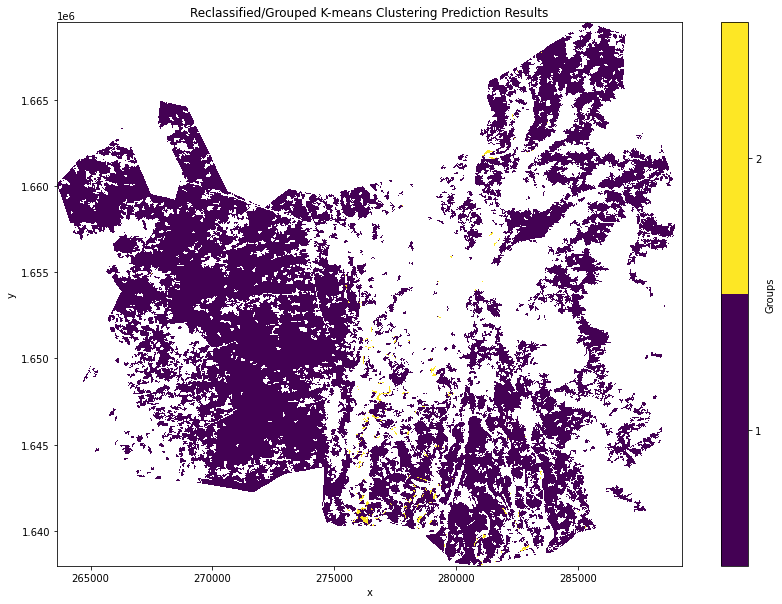

In [12]:
## Plot the reclassified image.
# Create a list of labels to use for your legend.
classes_present = [x for x in list(np.unique(grouped_predicted)) if np.isnan(x) == False]

# Create a colormap.
cmap = plt.cm.get_cmap("viridis", len(classes_present))
class_bins = list(np.arange(np.min(classes_present)-0.5 , np.max(classes_present)+1+0.5, 1))
norm = mpl.colors.BoundaryNorm(class_bins, len(classes_present))

fig, ax = plt.subplots(figsize=(14,10))
im = grouped_predicted.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False, ax=ax)
cbar=plt.colorbar(im, label='Groups');
cbar.set_ticks(classes_present)
plt.title("Reclassified/Grouped K-means Clustering Prediction Results");

In [13]:
# Sample the Reclassified K-Means clustering prediction results.
#reclassified_predicted_sampled_points = random_sampling(da = grouped_predicted,
#                                           n = 1000,
#                                           sampling='equal_stratified_random',
#                                           manual_class_ratios=None,
#                                           out_fname=f"{output_dir}/reclassified_kmeans_predicted_sample_points.geojson")

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [14]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [15]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-06-23'